In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.sparse import spdiags
from scipy import signal
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees,degrees2kilometers
from obspy.signal import filter as obspy_filter
import time
from scipy import interpolate
import obspy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
proj=ccrs.PlateCarree()

import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

import time

import sys
sys.path.append('/home/yaolinm/Projects/Mexico2/')
sys.path.append('/home/yaolinm/Projects/Mexico/a1das-v2-main/')

from funcs.bp import *
from funcs.mccc import *
from funcs.utils import *
from a1das import core

from numba import njit
import numba
import copy
import glob,os,h5py

In [2]:
from obspy.taup.taup_create import TauPCreate
model=TauPCreate('/home/yaolinm/Projects/Mexico/conventional_seis/mx.nd','/home/yaolinm/Projects/Mexico2/data/mx.npz')
v_mod=model.load_velocity_model()
model.create_tau_model(v_mod)
model.run()

In [50]:
eq=earthquake(-103.269,18.2377,25.5)
sub1=earthquake(-103.55,18.55,25.5)
sub2=earthquake(-104,18.85,25.5)
sub3=earthquake(-104.4,19.15,25.5)
longitude_range=[-104.5,-102.5]
latitude_range=[17.5,20.5]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)
x_mesh,y_mesh=grid.mesh()

mat=scipy.io.loadmat('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/posfib.mat')
channel_longs=mat['x0'][0]
channel_latis=mat['y0'][0]
selected_chs=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/egf1_s_selected_chs.npy')

das_latitudes,das_longitudes=[],[]
for i in range(0,len(selected_chs),20):
    das_latitudes.append(channel_latis[i])
    das_longitudes.append(channel_longs[i])

In [51]:
das_rtable=reference_table(model='iasp91',eq=eq,wave='P')       

corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(das_latitudes)):
        degrees.append(locations2degrees(das_latitudes[i],das_longitudes[i],corner[0],corner[1]))
        
das_rtable.cal_table(np.min(degrees)-0.1,np.max(degrees)+0.1,0.01)

das_rtable_S=reference_table(model='iasp91',eq=eq,wave='S')       

corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(das_latitudes)):
        degrees.append(locations2degrees(das_latitudes[i],das_longitudes[i],corner[0],corner[1]))
        
das_rtable_S.cal_table(np.min(degrees)-0.1,np.max(degrees)+0.1,0.01)

In [53]:
dt=np.zeros((2,len(das_latitudes)))    
for i in range(len(das_latitudes)):
    das_sensor=sensor(das_longitudes[i],das_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable)
    das_sensor.cal_epitime(sub1,das_rtable,etype='subevent')
    dt[0,i]=das_sensor.subevents[0]-das_sensor.epitime
    
    das_sensor=sensor(das_longitudes[i],das_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable_S)
    das_sensor.cal_epitime(sub1,das_rtable_S,etype='subevent')
    dt[1,i]=das_sensor.subevents[0]-das_sensor.epitime
np.save('data/dt2.npy',dt)

In [22]:
peaks=[]
npys=np.sort(glob.glob('/scratch/zspica_root/zspica0/yaolinm/mexico_syn/arrival_perturbation2/results/*'))
for npy in npys:
    master=np.load(npy)
    peak=np.unravel_index(np.argmax(master),master.shape)
    peaks.append((x_mesh[:,peak[0]][0],y_mesh[peak[1],:][0]))

(17.5, 19.5)

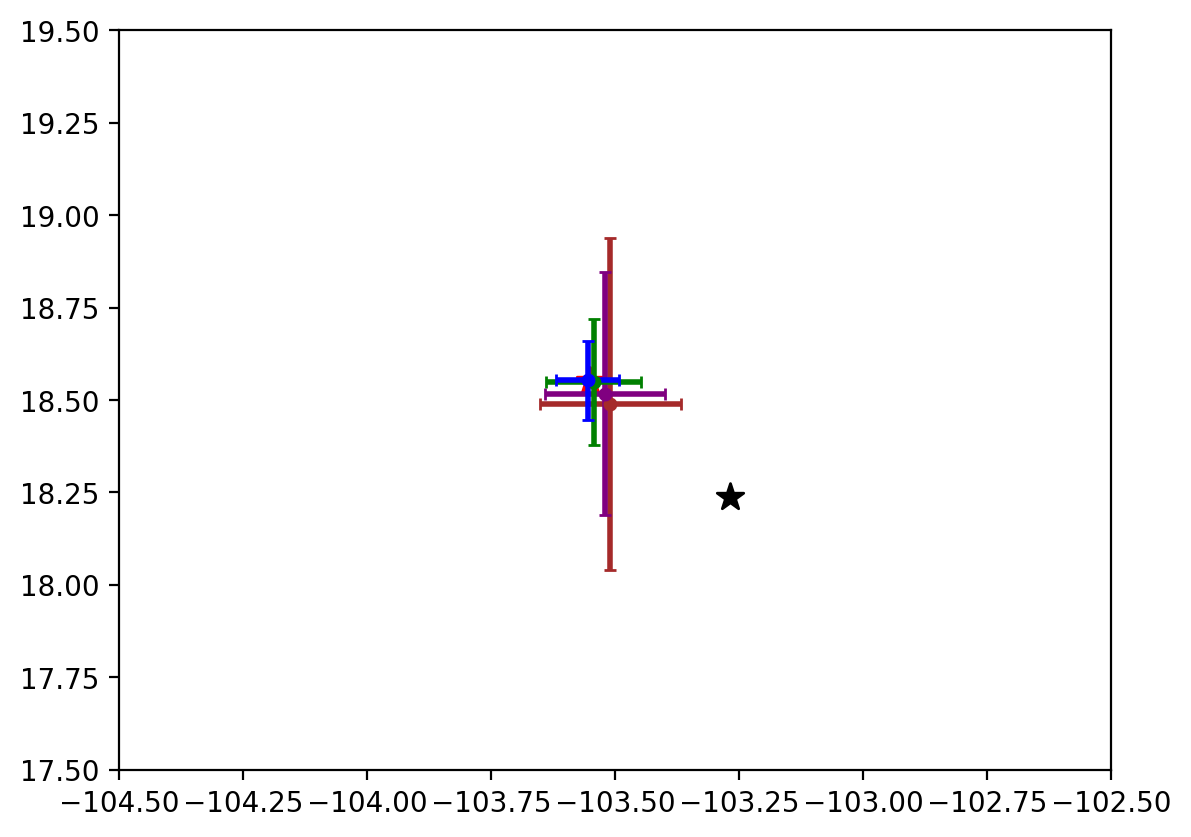

In [57]:
fig=plt.figure(dpi=200)
colors=['gold','blue','green','purple','brown']
arrival_p=[0.05,0.1,0.15,0.2,0.25]

plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)

for n in range(4,0,-1):
    center=np.mean(np.array(peaks[200*n:200*n+200]),axis=0)
    std=np.std(np.array(peaks[200*n:200*n+200]),axis=0)
    plt.errorbar(center[0], center[1], xerr=std[0], yerr=std[1], fmt='o', color=colors[n],markersize=4,
             ecolor=colors[n], elinewidth=2, capsize=2, label=r'$σ_t={}$'.format(arrival_p[n]))

plt.xlim(-104.5,-102.5)
plt.ylim(17.5,19.5)

In [70]:
# indices=[]
# for out in np.sort(glob.glob('/home/yaolinm/Projects/Mexico2/scripts/*.out')):
#     size = os.path.getsize(out)
#     if size >300:
#         indices.append(int(os.path.basename(out).split('_')[-1][:-4]))
# np.save('data/invalid_vmod_inds2.npy',np.array(indices))

In [71]:
indices=np.load('data/invalid_vmod_inds2.npy')
vmod_peaks=[[],[],[],[],[]]
npys=np.sort(glob.glob('/scratch/zspica_root/zspica0/yaolinm/mexico_syn/vmod_perturbation2/results/*'))

for n,npy in enumerate(npys):
    
    if n not in indices:
        ind=int(os.path.basename(npy)[:-4])//200
        master=np.load(npy)
        peak=np.unravel_index(np.argmax(master),master.shape)
        vmod_peaks[ind].append((x_mesh[:,peak[0]][0],y_mesh[peak[1],:][0]))

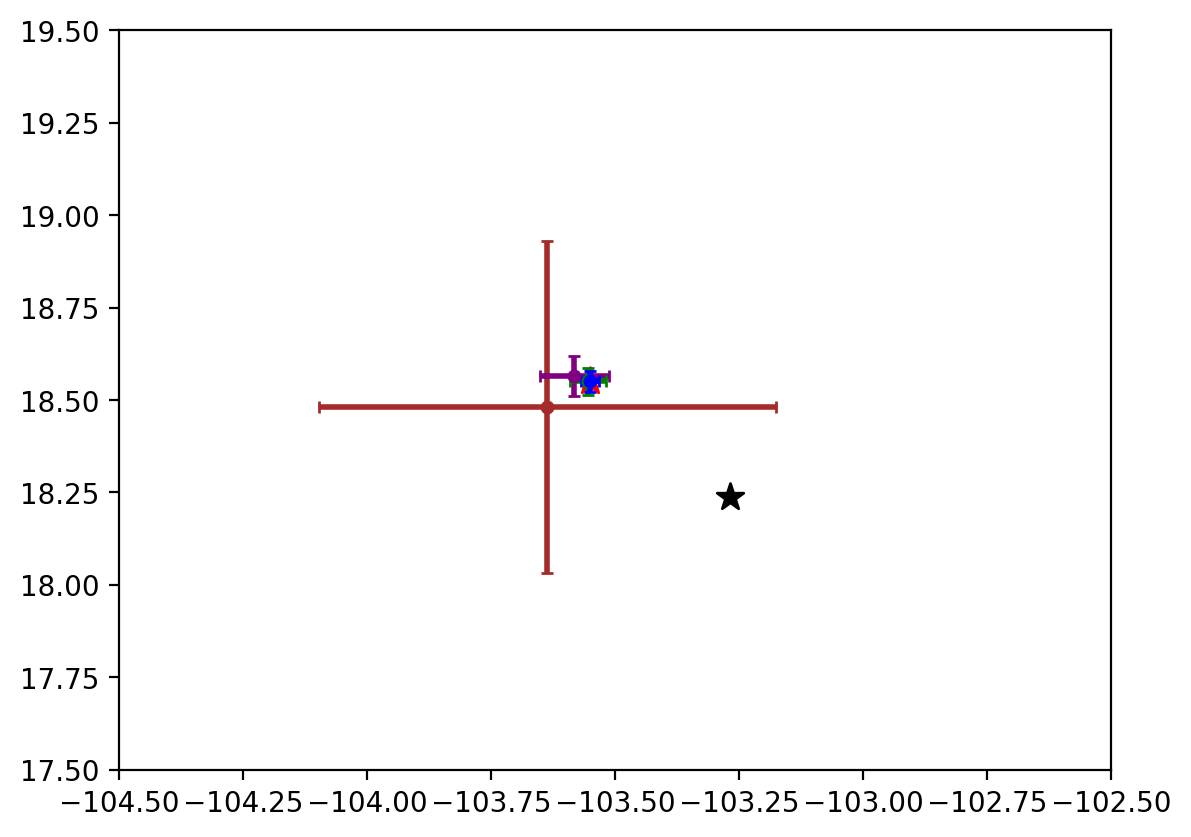

In [72]:
fig=plt.figure(dpi=200)
colors=['gold','blue','green','purple','brown']
arrival_p=[0.05,0.1,0.15,0.2,0.25]

plt.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=100)
plt.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=100)

for n in range(4,0,-1):
    center=np.mean(np.array(vmod_peaks[n]),axis=0)
    std=np.std(np.array(vmod_peaks[n]),axis=0)
    plt.errorbar(center[0], center[1], xerr=std[0], yerr=std[1], fmt='o', color=colors[n],markersize=4,
             ecolor=colors[n], elinewidth=2, capsize=2, label=r'$σ_t={}$'.format(arrival_p[n]))

plt.xlim(-104.5,-102.5)
plt.ylim(17.5,19.5)
plt.show()

In [73]:
import netCDF4 as nc
import cmocean
file='/home/yaolinm/Projects/Mexico2/data/gebco_2024_n21.0_s16.0_w-106.0_e-101.0.nc'
dataset = nc.Dataset(file, 'r')
variable = dataset.variables['elevation']
bmap = variable[:] 

from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
resized_x_mesh=zoom(x_mesh,zoom=4,order=1)
resized_y_mesh=zoom(y_mesh,zoom=4,order=1)

colors = ['white', 'lightgray', 'gray', 'dimgray']
bounds = [-4000, 0, 1, 2, 4000]  # Define boundaries between colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

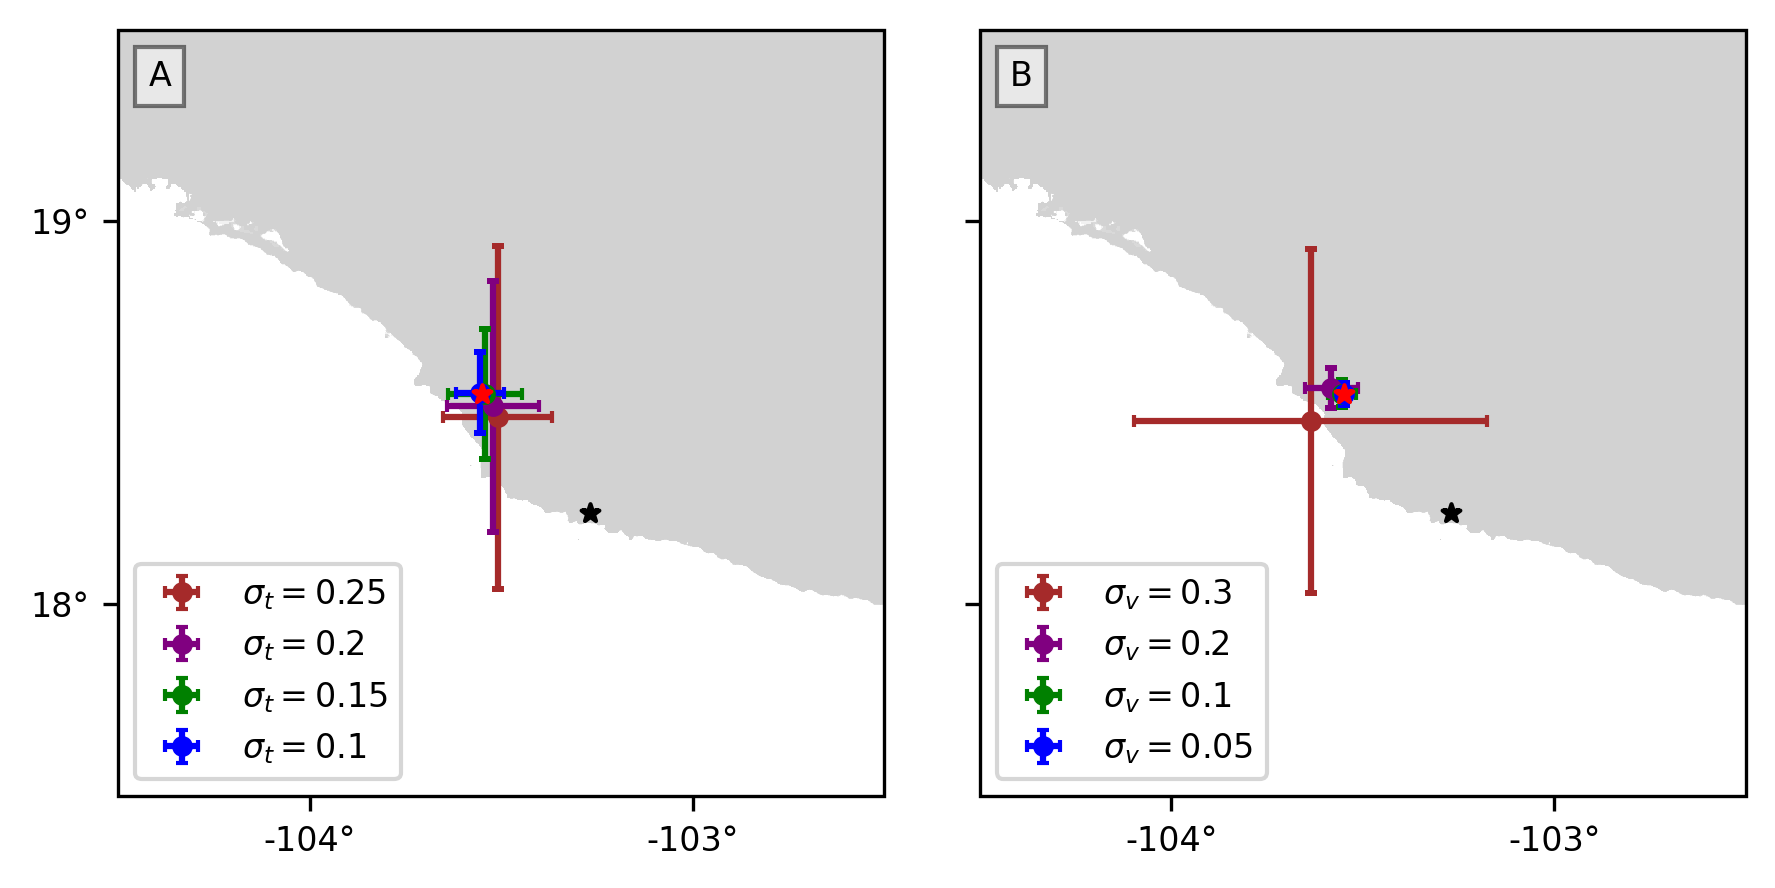

In [87]:
fig=plt.figure(dpi=300,figsize=(7,6))
fig.subplots_adjust(hspace=0.6,wspace=2)
proj=cartopy.crs.PlateCarree()
arrival_p=[0.05,0.1,0.15,0.2,0.25]
vmod_p=[0.02,0.05,0.1,0.2,0.3]

# colors=['#8794b6','#91b3ce','#f1cac4','#f7a444','#669568']
# colors=['#8386a8','#d15c6b','#f5cf36','#8fb943','#78b9d2']
colors=['gold','blue','green','purple','brown']

ax1 = plt.subplot2grid(shape=(10,12), loc=(0,0), colspan=6,rowspan=10, projection=proj)
ax2 = plt.subplot2grid(shape=(10,12), loc=(0,6), colspan=6,rowspan=10, projection=proj)


bs=ax1.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)

ax1.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=20)
ax1.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=20,zorder=999)  

for n in range(4,0,-1):
    center=np.mean(np.array(peaks[200*n:200*n+200]),axis=0)
    std=np.std(np.array(peaks[200*n:200*n+200]),axis=0)
    ax1.errorbar(center[0], center[1], xerr=std[0], yerr=std[1], fmt='o', color=colors[n],markersize=4,
             ecolor=colors[n], elinewidth=1.5, capsize=1.5, label=r'$σ_t={}$'.format(arrival_p[n]))
  
ax1.set_yticks([18, 19])
ax1.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax1.set_ylim(17.5,19.5)
ax1.set_xticks([-104, -103])
ax1.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)
ax1.set_xlim(-104.5,-102.5)
ax1.legend(fontsize=8,loc=3)
at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax1.add_artist(at)


ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=20)
ax2.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=20,zorder=999)  
for n in range(4,0,-1):
    center=np.mean(np.array(vmod_peaks[n]),axis=0)
    std=np.std(np.array(vmod_peaks[n]),axis=0)
    ax2.errorbar(center[0], center[1], xerr=std[0], yerr=std[1], fmt='o', color=colors[n],markersize=4,
             ecolor=colors[n], elinewidth=1.5, capsize=1.5, label=r'$σ_v={}$'.format(vmod_p[n]))
  
ax2.set_yticks([18, 19])
ax2.set_yticklabels(['',''], fontsize=8)
ax2.set_ylim(17.5,19.5)
ax2.set_xticks([-104, -103])
ax2.set_xticklabels([f"{x}°" for x in [-104, -103]], fontsize=8)
ax2.set_xlim(-104.5,-102.5)
ax2.legend(fontsize=8,loc=3)
at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax2.add_artist(at)

In [77]:
indices

array([343, 601, 603, 604, 607, 612, 618, 620, 623, 625, 635, 637, 653,
       656, 657, 659, 663, 664, 667, 672, 673, 676, 677, 682, 683, 694,
       698, 699, 700, 716, 724, 725, 726, 728, 730, 735, 747, 749, 756,
       760, 766, 774, 775, 780, 782, 784, 790, 791, 796, 797, 800, 801,
       804, 805, 811, 815, 816, 818, 820, 821, 826, 827, 828, 829, 833,
       839, 840, 841, 842, 844, 846, 851, 854, 855, 858, 859, 860, 863,
       865, 872, 873, 874, 880, 884, 886, 891, 894, 896, 897, 899, 901,
       902, 903, 905, 907, 908, 910, 914, 915, 917, 918, 922, 923, 924,
       925, 928, 929, 930, 931, 945, 947, 949, 950, 951, 952, 955, 958,
       959, 961, 965, 966, 967, 971, 972, 975, 976, 977, 980, 982, 983,
       989, 991, 992, 993, 994, 997])